<a href="https://colab.research.google.com/github/Akechi1412/Vietnamese-Review-Classification/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install python3.9
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.9 is already the newest version (3.9.19-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
update-alternatives: warning: forcing reinstallation of alternative /usr/bin/python3.9 because link group python3 is broken
update-alternatives: warning: not replacing /usr/bin/python3 with a link


In [2]:
!sudo apt install python3.9-distutils
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!python3.9 get-pip.py

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.9-distutils is already the newest version (3.9.19-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2574k  100 2574k    0     0  69.8M      0 --:--:-- --:--:-- --:--:-- 71.8M
/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existin

In [4]:
!pip uninstall -y numpy matplotlib tensorflow keras
!pip install numpy matplotlib tensorflow keras
!pip install pyvi https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: matplotlib 3.8.4
Uninstalling matplotlib-3.8.4:
  Successfully uninstalled matplotlib-3.8.4
Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
Found existing installation: keras 3.2.1
Uninstalling keras-3.2.1:
  Successfully uninstalled keras-3.2.1
/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached matplotlib-3.8.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached tensorflow-2.16.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached keras-3.2.1-

In [5]:
!rm -rf Vietnamese-Review-Classification
!git clone https://github.com/Akechi1412/Vietnamese-Review-Classification
%cd Vietnamese-Review-Classification
!rm -f ./models/review_model.h5

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Cloning into 'Vietnamese-Review-Classification'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 130 (delta 29), reused 29 (delta 28), pack-reused 96
Receiving objects: 100% (130/130), 30.15 MiB | 7.62 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Vietnamese-Review-Classification
/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)


Preparing data...
Data size: 9000
Max number of words: 476
['đọc', 'cuốn', 'sách', 'tập', '1', 'mình', 'đã', 'nhận', 'ra', 'những', 'điều', 'thiếu sót', 'trong', 'quá trình', 'quản trị', 'doanh nghiệp', 'của', 'mình', 'chưa', 'có', 'tầm', 'nhìn', 'sứ mệnh', 'và', 'các', 'giá trị', 'cốt lõi', 'dẫn', 'đến', 'lúng túng', 'và', 'không thể', 'vận hành', 'doanh nghiệp', '1', 'cách', 'trơn tru', 'trong', 'sách', 'còn', 'có', 'nhiều', 'quà', 'tặng', 'đi', 'kèm', 'cực', 'giá trị', 'mình', 'đọc', 'mà', 'quên', 'cả', 'ăn', 'luôn', 'đúng', 'là', 'cuốn', 'sách', 'giá trị', 'trong', 'các', 'cuốn', 'sách', 'mình', 'đã', 'từng', 'đọc']
0


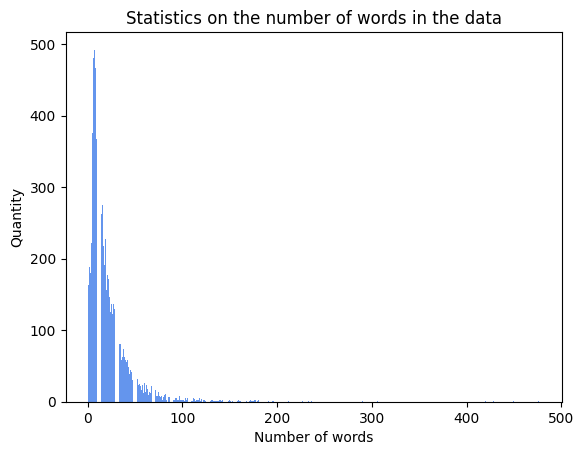

In [6]:
from utils.data_preparing import prepare_data
from utils.plotter import plot_reviews_data

x_data, y_data = prepare_data()

print(f'Data size: {len(x_data)}')
print(f'Max number of words: {len(max(x_data, key=len))}')
print(x_data[0])
print(y_data[0])

plot_reviews_data(x_data)

In [7]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=1/3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

6000 6000
1500 1500
1500 1500


In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import pickle

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Save tokenize
with open('./models/review_tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Pad sequences to ensure uniform length
max_len = 200
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

print(f'({len(x_train_pad)}, {len(x_train_pad[0])})')
print(f'({len(x_val_pad)}, {len(x_val_pad[0])})')
print(f'({len(x_test_pad)}, {len(x_test_pad[0])})')

# Create one hot
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

ImportError: /usr/local/lib/python3.10/site-packages/tensorflow/python/platform/../../libtensorflow_framework.so.2: undefined symbol: _ZTIN6snappy4SinkE

In [ ]:
import numpy as np

x_train_pad = np.array(x_train_pad)
x_val_pad = np.array(x_val_pad)
x_test_pad = np.array(x_test_pad)

y_train_one_hot = np.array(y_train_one_hot)
y_val_one_hot = np.array(y_val_one_hot)
y_test_one_hot = np.array(y_test_one_hot)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.layers import SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import regularizers

# Build RNN model
model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(units=256, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.L2(1e-6)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.L2(1e-6)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.L2(1e-6)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=16, activation='relu', kernel_regularizer=regularizers.L2(1e-6)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train and save the model,
filepath = './models/review_model.h5'
checkpoint = ModelCheckpoint(
  filepath,
  monitor='val_loss',
  verbose=1,
  save_best_only=True,
  mode='min'
)
callbacks_list = [checkpoint]
history = model.fit(
  x_train_pad, y_train_one_hot,
  batch_size=40,
  epochs=10,
  validation_data=(x_val_pad, y_val_one_hot),
  callbacks=callbacks_list
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          978944    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1030531 (3.93 MB)
Trainable params: 1030531 (3.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
147/150 [============================>.] - ETA: 0s - loss: 0.7435 - accuracy: 0.6741
Epoch 1: val_loss improved from inf to 0.54564, saving

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/150 [============================>.] - ETA: 0s - loss: 0.4503 - accuracy: 0.8243
Epoch 2: val_loss improved from 0.54564 to 0.51535, saving model to ./models/review_model.h5
150/150 [==============================] - 6s 40ms/step - loss: 0.4494 - accuracy: 0.8248 - val_loss: 0.5153 - val_accuracy: 0.8087
Epoch 3/10
148/150 [============================>.] - ETA: 0s - loss: 0.3333 - accuracy: 0.8785
Epoch 3: val_loss did not improve from 0.51535
150/150 [==============================] - 5s 36ms/step - loss: 0.3329 - accuracy: 0.8788 - val_loss: 0.5398 - val_accuracy: 0.8027
Epoch 4/10
145/150 [============================>.] - ETA: 0s - loss: 0.2328 - accuracy: 0.9236
Epoch 4: val_loss did not improve from 0.51535
150/150 [==============================] - 3s 17ms/step - loss: 0.2343 - accuracy: 0.9223 - val_loss: 0.6349 - val_accuracy: 0.7907
Epoch 5/10
145/150 [============================>.] - ETA: 0s - loss: 0.1819 - accuracy: 0.9416
Epoch 5: val_loss did not improve from 0.515

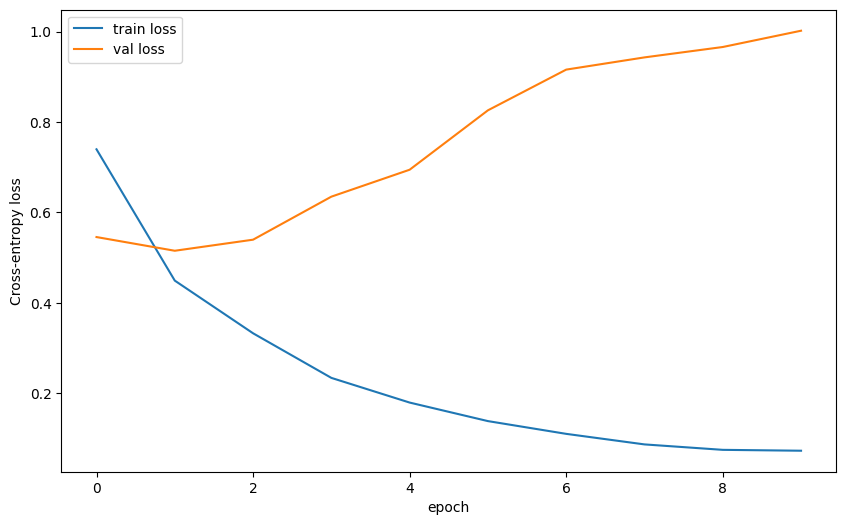

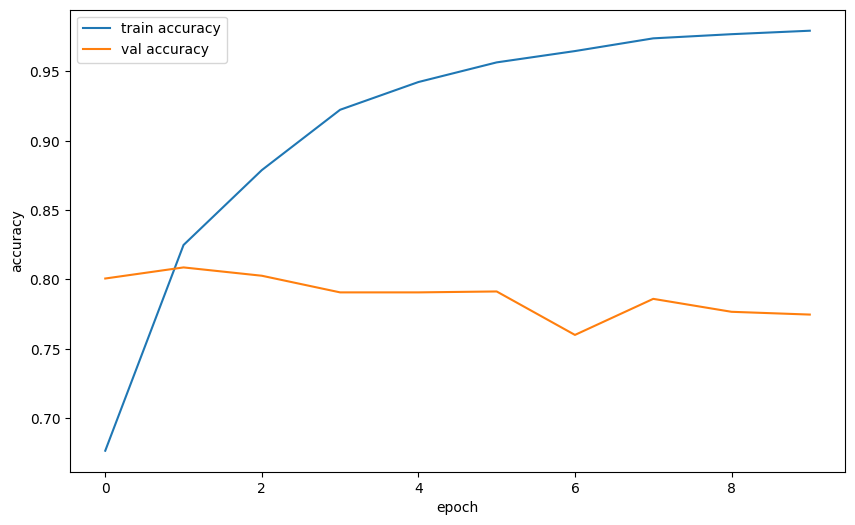

In [ ]:
from utils.plotter import plot_history_model

plot_history_model(history)

In [ ]:
from sklearn.metrics import confusion_matrix

score, acc = model.evaluate(x_test_pad, y_test_one_hot, batch_size=15, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

y_pred = model.predict(x_test_pad, batch_size=15)
y_test_single = np.argmax(y_test_one_hot, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_pred_single)
print("Confusion Matrix:")
print(conf_matrix)

100/100 - 1s - loss: 1.0164 - accuracy: 0.7800 - 508ms/epoch - 5ms/step
Test score: 1.0164152383804321
Test accuracy: 0.7799999713897705
100/100 [==============================] - 1s 4ms/step
Confusion Matrix:
[[719  40  42]
 [ 54 377  72]
 [ 50  72  74]]
